# Student's information:
**Ho va ten**: Đỗ Viết Đoàn

**Mssv**: 18020313

**Lop**: K63-K1

#  Predict the Relevance of Search Results on HomeDepot.com
> *Shoppers searching through Home Depot's product authority require correct results to their queries on home improvement. Currently human raters gauge search relevance and the impact of potential changes to the search algorithm. Home Depot aims to "develop a model that can accurately predict the relevance of search results.*

In this competition, Home Depot is asking Kagglers to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. Currently, human raters evaluate the impact of potential changes to their search algorithms, which is a slow and subjective process. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to increase the number of iterations their team can perform on the current search algorithms.
 wh
## Input:
A number of products and real customer search terms from Home Depot's website along with the ground truth labels (the relevance) which have been evaluated by at least three human raters .
## Output: 
A relevance score for the provided combinations of search terms and products

## Unzip data

In [ ]:
!unzip ../input/home-depot-product-search-relevance/product_descriptions.csv.zip
!unzip ../input/home-depot-product-search-relevance/train.csv.zip
!unzip ../input/home-depot-product-search-relevance/test.csv.zip
!unzip ../input/home-depot-product-search-relevance/attributes.csv.zip

## Import required libraries

In [ ]:
from sklearn import pipeline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import os
# Any results you write to the current directory are saved as output.
import json
import warnings; warnings.filterwarnings("ignore");
import time
start_time = time.time()

from sklearn.ensemble import RandomForestRegressor
from sklearn import pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer
#from nltk.metrics import edit_distance
from nltk.stem.porter import *
stemmer = PorterStemmer()
#from nltk.stem.snowball import SnowballStemmer #0.003 improvement but takes twice as long as PorterStemmer
from bs4 import BeautifulSoup
import re
#import enchant
import random
random.seed(2016)
from scipy.stats import norm  
import seaborn as sns # data visualization
%matplotlib inline
import matplotlib.pyplot as plt


# **Data explore**

## File descriptions

- `train.csv` - the training set, contains products, searches, and relevance scores
- `test.csv` - the test set, contains products and searches. You must predict the relevance for these pairs.
- `product_descriptions.csv` - contains a text description of each product. You may join this table to the training or test set via the product_uid.
- `attributes.csv` -  provides extended information about a subset of the products (typically representing detailed technical specifications). Not every product will have attributes.
- `sample_submission.csv` - a file showing the correct submission format
- `relevance_instructions.docx` - the instructions provided to human raters

## Load data from csv file into Pandas DataFrame

In [ ]:
df_train = pd.read_csv('train.csv', encoding="ISO-8859-1") #update here
df_test = pd.read_csv('test.csv', encoding="ISO-8859-1") #update here
df_pro_desc = pd.read_csv('product_descriptions.csv')[:64000] #update here
df_attr = pd.read_csv('attributes.csv')

## Take a look at each df
In order to understand our data, we can look at each variable and try to understand their meaning and relevance to this problem. This is time-consuming, but it will give us the flavour of our dataset.

**Data fields:**
- `id` - a unique Id field which represents a (search_term, product_uid) pair
- `product_uid` - an id for the products
- `product_title` - the product title
- `product_description` - the text description of the product (may contain HTML content)
- `search_term` - the search query
- `relevance` - the average of the relevance ratings for a given id
- `name` - an attribute name
- `value` - the attribute's value

### Get some extra info about our data:

Check null values in each dataframe

In [ ]:
print(f"training data has {df_train.isnull().values.sum()} null values:")
print(f"testing data has {df_test.isnull().values.sum()} null values:")
print(f"attribute data has {df_attr.isnull().values.sum()} null values:")
print(f"description data has {df_pro_desc.isnull().values.sum()} null values:")

### Analyze train data

In [ ]:
def get_df_info(df):
    print("df columns: \n",df.columns)
    print(f"df shape: \n",df.shape)
    print(f"df data types: \n",df.dtypes)
    return df.head(10)

In [ ]:
get_df_info(df_train)

In [ ]:
print("there are in total {} products ".format(len(df_train.product_title.unique())))
print("there are in total {} search query ".format(len(df_train.search_term.unique())))
print("there are in total {} product_uid".format(len(df_train.product_uid.unique())))

### Analyze test data

In [ ]:
get_df_info(df_test)

In [ ]:
print("there are in total {} products ".format(len(df_test.product_title.unique())))
print("there are in total {} search query ".format(len(df_test.search_term.unique())))
print("there are in total {} product_uid".format(len(df_test.product_uid.unique())))

### Analyze product description data

Contain `product_id` and `product_description`

`product_description` seems contain valueable infomation and can be usefull later



In [ ]:
get_df_info(df_pro_desc)

In [ ]:
print("there are in total {} product_uid ".format(len(df_pro_desc.product_uid.unique())))
print("there are in total {} product_descriptions ".format(len(df_pro_desc.product_description.unique())))

In [ ]:
(df_pro_desc.product_description.str.count('\d+') + 1).hist(bins=30)
(df_pro_desc.product_description.str.count('\W')+1).hist(bins=30)

In [ ]:
print('Total {} html tags contains in product description'.format(df_pro_desc.product_description.str.count('<br$').values.sum()))

Lets see some of them

In [ ]:
df_pro_desc[df_pro_desc.product_description.str.contains("<br")].values.tolist()[-2:]

In [ ]:
df_pro_desc.product_description.str.contains("Click here to review our return policy for additional information regarding returns").values.sum()

### Join train, test with product_descriptions by product_uid

In [ ]:
train_merged = pd.merge(df_train, df_pro_desc, on='product_uid')
test_merged = pd.merge(df_test, df_pro_desc, on='product_uid')

## **Get into details**
**`relevance`**

> `relevance` is our goal. It's like when we're going to a party. We always have a reason to be there.

The relevance is a number between 1 (not relevant) to 3 (highly relevant). For example, a search for "AA battery" would be considered highly relevant to a pack of size AA batteries (relevance = 3), mildly relevant to a cordless drill battery (relevance = 2), and not relevant to a snow shovel (relevance = 1).

In [ ]:
sns.countplot(train_merged.relevance)

In [ ]:
hight_relevance = train_merged.loc[train_merged["relevance"] == 3]
hight_relevance[['product_title', 'search_term']].head()

In [ ]:
train_merged.relevance.plot(kind='hist', density=True)

mu, std = norm.fit(train_merged.relevance)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Results: mu = %.3f,  std = %.3f" % (mu, std)
plt.title(title)

plt.show()

The relevancy score is between 1 and 3. Because the density of product whose relevancy score is between 2 and 3 is higher we can conclude that most of search query has been classifield between 2 and 3

The histogram of relevancy score doesn't follow standard distribution pattern

**`search_term`** 

`search_term` is the words that customers use to search for products.

In [ ]:
train_merged[train_merged.search_term.str.contains("^\\d+ . \\d+$")].head(10)

In [ ]:
df_train_distribution = train_merged.search_term.str.split().apply(len).value_counts().sort_index()
df_test_distribution = test_merged.search_term.str.split().apply(len).value_counts().sort_index()
fig, (ax1, ax2) = plt.subplots(2, sharex=False)
fig.suptitle('Number of word in search term of train and test set')

#ax1.hist(df_train_distribution)
df_train_distribution.plot(kind = 'pie', colormap = 'pink', figsize = (10,10), ax = ax1, title = 'in train data')
df_test_distribution.plot(kind = 'pie', colormap = 'jet', figsize = (10, 10), ax = ax2, title = 'in test data')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=False)
fig.suptitle('Number of word in search term of train and test set')
df_train_distribution.plot(kind = 'bar',colormap = 'pink',sharex = True, figsize = (10,5), ax = ax1, title = 'train data')
df_test_distribution.plot(kind = 'bar', colormap = 'autumn', figsize = (10,5), ax = ax2, title = 'test data')


Some query in dataset training are too straight, it's hard to guess exactly what user meant in terms of broad sense

Some of the search query in dataset training has too specific meaning like 8 4616809045 9

Number of diggits appearence in the product title tends to be greater number of characters for dataset training (and the same is true for search query field)

`product_description`

In [ ]:
df_train_pro_desc_distribution = train_merged.product_description.str.split().apply(len).divmod(10)[0].value_counts().nlargest(40).sort_index()
df_test_pro_desc_distribution = test_merged.product_description.str.split().apply(len).divmod(10)[0].value_counts().nlargest(40).sort_index()
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Number of word in product description of train and test set')

df_train_pro_desc_distribution.plot(kind = 'bar', colormap = 'pink',sharex = True, figsize = (10,5), ax = ax1, title = 'in train')
df_test_pro_desc_distribution.plot(kind = 'bar', colormap = 'autumn', figsize = (10, 5), ax = ax2, title = 'in test')

# Preprocessing data

## Transform `dt_attributes`
- We will transform attributes into new dataframe which contain two columns `product_uid` and `brand` 

- Cause not every fields has `product attributes` , when we merge them with `dt_description`, some `NAN` values will show up. Therefor, we need to handle `NAN` values  after that.


### Merge them all

In order to have a general sight to our data, we will merge train and test set.

In [ ]:
df_brand = df_attr[df_attr.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})
num_train = df_train.shape[0]
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')
df_all = pd.merge(df_all, df_brand, how='left', on='product_uid')

In [ ]:
df_all.columns

In [ ]:
from nltk.corpus import stopwords # Import the stop word list
#stop_w = set(stopwords.words('english'))

### Clean the data

First, remove html tags

In [ ]:
# use Beautifulsoup lib to remove html tags in text
def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

Then, we remove special characters which is susposed to contain very few information and standardlize mesurement unit (ex: inches/inch/in -> 1in; pounds/pound/lbs/lb -> 1lb ).

In [ ]:
#stopwords are the words contain very little or no imformation. 
stop_w = ['for', 'xbi', 'and', 'in', 'th','on','sku','with','what','from','that','less','er','ing'] #'electr','paint','pipe','light','kitchen','wood','outdoor','door','bathroom'

strNum = {'zero':0,'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9}
spell_check = json.load(open('../input/spell-check-home-depot/spell_check.json','r'))
def str_stem(s):
    if isinstance(s, str):
        s = re.sub(r"(\w)\.([A-Z])", r"\1 \2", s) #Split words with a.A
        s = s.lower()
        s = s.replace("  "," ") #remove double space
        #remove special character and split number
        s = s.replace(",","") #could be number / segment later
        s = s.replace("$"," ")
        s = s.replace("?"," ")
        s = s.replace("-"," ")
        s = s.replace("//","/")
        s = s.replace("..",".")
        s = s.replace(" / "," ")
        s = s.replace(" \\ "," ")
        s = s.replace("."," . ")
        s = re.sub(r"(^\.|/)", r"", s)
        s = re.sub(r"(\.|/)$", r"", s)
        s = re.sub(r"([0-9])([a-z])", r"\1 \2", s)
        s = re.sub(r"([a-z])([0-9])", r"\1 \2", s)
        s = s.replace(" x "," xbi ")
        s = re.sub(r"([a-z])( *)\.( *)([a-z])", r"\1 \4", s)
        s = re.sub(r"([a-z])( *)/( *)([a-z])", r"\1 \4", s)
        s = s.replace("*"," xbi ")
        s = s.replace(" by "," xbi ")
        #convert mesurement unit to standard form.
        s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
        s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
        s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
        s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
        s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
        s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
        s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
        s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
        s = s.replace("°"," degrees ")
        s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", s)
        s = s.replace(" v "," volts ")
        s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", s)
        s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", s)
        s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", s)
        s = s.replace("  "," ")
        s = s.replace(" . "," ")
        # filter out stop words
        s = (" ").join([z for z in s.split(" ") if z not in stop_w])
        # convert string number to number
        s = (" ").join([str(strNum[z]) if z in strNum else z for z in s.split(" ")])
        s = (" ").join([stemmer.stem(z) for z in s.split(" ")])
        s = remove_html_tag(s)
        s = s.lower()
        #fix the missed spell in text
        for (k,v) in spell_check.items():
            s = s.replace(k,v)
        return s
    else:
        return "null"

Apply preprocessing func to `product_title`, `search_term`, `product_description`, and `brand`

In [ ]:
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stem(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stem(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stem(x))
df_all['brand'] = df_all['brand'].map(lambda x:str_stem(x))

# Feature engineering
> Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

The features in your data will directly influence the predictive models you use and the results you can achieve.

You can say that: the better the features that you prepare and choose, the better the results you will achieve. It is true, but it also misleading.

The results you achieve are a factor of the model you choose, the data you have available and the features you prepared. Even your framing of the problem and objective measures you’re using to estimate accuracy play a part. Your results are dependent on many inter-dependent properties.

You need great features that describe the structures inherent in your data.
### Create new field 
we can enrich the infomation by constructing of new features from raw data
For example, we will have `product_info` if concating `search_term`,`product_title`  with `product_description` separated by `tab`

In [ ]:
df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title'] +"\t"+df_all['product_description']

Create num columns based on text columns

* count number of words in `search_term`
* count number of words in `product_title`
* count number of words in `product description`
* count number of words in `brand`


In [ ]:
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_title'] = df_all['product_title'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_description'] = df_all['product_description'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_brand'] = df_all['brand'].map(lambda x:len(x.split())).astype(np.int64)

In [ ]:
def seg_words(str1, str2):
    '''
    str1: search_term
    str2: product_tilte
    '''
    str2 = str2.lower()
    str2 = re.sub("[^a-z0-9./]"," ", str2)
    str2 = [s for s in set(str2.split()) if len(s)>2]
    words = str1.lower().split(" ")
    s = []
    for word in words:
        if len(word)>3:
            s1 = []
            s1 += segmentit(word,str2,True)
            #print(s1)
            if len(s)>1:
                s += [z for z in s1 if z not in ['er','ing','s','less'] and len(z)>1]
            else:
                s.append(word)
        else:
            s.append(word)
    return (" ".join(s))

In [ ]:
def segmentit(s, txt_arr, t):
    st = s
    r = []
    for j in range(len(s)):
        for word in txt_arr:
            if word == s[:-j]:
                r.append(s[:-j])
                #print(s[:-j],s[len(s)-j:])
                s=s[len(s)-j:]
                r += segmentit(s, txt_arr, False)
    if t:
        i = len(("").join(r))
        if not i==len(st):
            r.append(st[i:])
    return r


In [ ]:
df_all['search_term'] = df_all['product_info'].map(lambda x:seg_words(x.split('\t')[0],x.split('\t')[1]))

In [ ]:

def str_common_word(str1, str2):
    words, cnt = str1.split(), 0
    for word in words:
        if str2.find(word)>=0:
            cnt+=1
    return cnt

## Numeric feature: 
### counting

In [ ]:
#count number of times the last word in title appear in search term
df_all['query_last_word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0].split(" ")[-1],x.split('\t')[1]))
#count number of times the last word in product_description appear in search term
df_all['query_last_word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0].split(" ")[-1],x.split('\t')[2]))
#count number of times each word in product_info appear in search term
df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
#count number of times each word in product_description appear in search term
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

In [ ]:
#count number of time each word in string1 appear in string2
def str_whole_word(str1, str2, i_):
    cnt = 0
    while i_ < len(str2):
        i_ = str2.find(str1, i_)
        if i_ == -1:
            return cnt
        else:
            cnt += 1
            i_ += len(str1)
    return cnt

In [ ]:
df_all['query_in_title'] = df_all['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[1],0))
df_all['query_in_description'] = df_all['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[2],0))

### Caculating ratio

In [ ]:
df_all['ratio_title'] = df_all['word_in_title']/df_all['len_of_query']
df_all['ratio_description'] = df_all['word_in_description']/df_all['len_of_query']
df_all['attr'] = df_all['search_term']+"\t"+df_all['brand']
df_all['word_in_brand'] = df_all['attr'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['ratio_brand'] = df_all['word_in_brand']/df_all['len_of_brand']

## String similarity feature
### Jaccard similiraty:
The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations

![image.png](https://neo4j.com/docs/graph-data-science/current/_images/jaccard.png)

In [ ]:
!pip install textdistance

In [ ]:
import textdistance
df_all['jaccard_sim_desc'] = df_all['product_info'].map(lambda x:textdistance.jaccard(x.split('\t')[0],x.split('\t')[2]))
df_all['jaccard_sim_title'] = df_all['product_info'].map(lambda x:textdistance.jaccard(x.split('\t')[0],x.split('\t')[1]))

### Levenshtein distance

The Levenshtein distance between two strings is defined as the minimum number of edits needed to transform one string into the other, with the allowable edit operations being insertion, deletion, or substitution of a single character.
* So a Levenshtein distance of 0 means: both strings are equal
* The maximum Levenshtein distance (all chars are different) is max(string1.length, string2.length)

For example, "Hallo", "Hello" -> Levenstein distance 1 Max Levenstein distance for this two strings is: 5. So the 20% of the characters do not match.

In [ ]:
df_all['levenshtein_sim_desc'] = df_all['product_info'].map(lambda x:textdistance.levenshtein(x.split('\t')[0],x.split('\t')[2]))
df_all['levenshtein_sim_title'] = df_all['product_info'].map(lambda x:textdistance.levenshtein(x.split('\t')[0],x.split('\t')[1]))

In [ ]:
df_all['mra_sim_desc'] = df_all['product_info'].map(lambda x:textdistance.mra(x.split('\t')[0],x.split('\t')[2]))
df_all['mra_sim_title'] = df_all['product_info'].map(lambda x:textdistance.mra(x.split('\t')[0],x.split('\t')[1]))

In [ ]:
df_brand = pd.unique(df_all.brand.ravel())
d={}
i = 1000
for s in df_brand:
    d[s]=i
    i+=3
df_all['brand_feature'] = df_all['brand'].map(lambda x:d[x])
df_all['search_term_feature'] = df_all['search_term'].map(lambda x:len(x))


## Word embedding feature
### Word2vec and gensim
Word2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men, and human might cluster in one corner, while yellow, red and blue cluster together in another.

Gensim is an open source python library for natural language processing and it was developed and is maintained by the Czech natural language processing researcher Radim Řehůřek. Gensim library will enable us to perform word embeddings simple and effeciently.

In [ ]:
from nltk.corpus import brown
import gensim
embed_model = gensim.models.Word2Vec(brown.sents())
embed_model.save('brown.embedding')
model = gensim.models.Word2Vec.load('brown.embedding')

In [ ]:
def embedding_sim_cal(s, t, i):
    _sum = 0
    avg = 0
    if len(s.split()) == 0 :
        return 0
    for s_word in s.split():
        _max = 0
        for t_word in t.split():
            if ((s_word in model.wv) and (t_word in model.wv)):
                _max = max(_max, model.wv.similarity(s_word, t_word))
        _sum += _max
    avg = _sum/ len(s.split())
    return avg

In [ ]:
df_all['word_ebed_similarity'] = df_all['product_info'].map(lambda x:embedding_sim_cal(x.split('\t')[0],x.split('\t')[2],0))
df_all.to_csv('df_all.csv')

## TF-IDF similarity measure feature at char level
**What is TF-IDF?**

TF-IDF is an information retrieval and information extraction subtask which aims to express the importance of a word to a document which is part of a colection of documents which we usually name a corpus. It is usually used by some search engines to help them obtain better results which are more relevant to a specific query

TF-IDF stands for Term Frequency — Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.
This is performed by looking at how many times a word appears into a document while also paying attention to how many times the same word appears in other documents in the corpus.
The rationale behind this is the following:
a word that frequently appears in a document has more relevancy for that document, meaning that there is higher probability that the document is about or in relation to that specific word
a word that frequently appears in more documents may prevent us from finding the right document in a collection; the word is relevant either for all documents or for none. Either way, it will not help us filter out a single document or a small subset of documents from the whole set.

* N is the number of documents we have in our dataset
* d is a given document from our dataset
* D is the collection of all documents
* w is a given word in a document

First step is to calculate the term frequency, our first measure if the score.

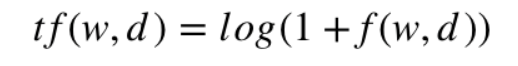

Second step is to calculate the inverse term frequency.

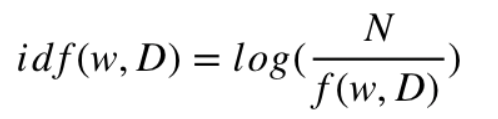

Final step is to compute the TF-IDF score by the following formula:

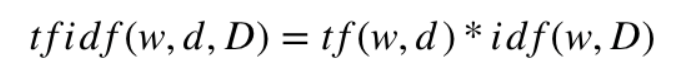

But in here, we will use TfidfVectorizer() which has already implimented in sklearn lib.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range = (3,3), max_features = 1500)
tfidf_des = tfidf.fit_transform(df_all.product_description).toarray()
tfidf_search = tfidf.transform(df_all.search_term).toarray()
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')

# Modeling
## Loss function: RMSE

In [ ]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

RMSE  = make_scorer(fmean_squared_error, greater_is_better=False)

In [ ]:

class custom_regression_vals(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, hd_searches):
        d_col_drops=['id','relevance','search_term','product_title','product_description','product_info','attr','brand']
        hd_searches = hd_searches.drop(d_col_drops,axis=1).values
        return hd_searches

class custom_txt_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key].apply(str)

Split data into train and test data

In [ ]:
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']
y_train = df_train['relevance'].values
X_train = df_train[:]
X_test = df_test[:]
print("--- Features Set: %s minutes ---" % round(((time.time() - start_time)/60),2))

### RandomforestRegesssor

**A random forest regressor.**

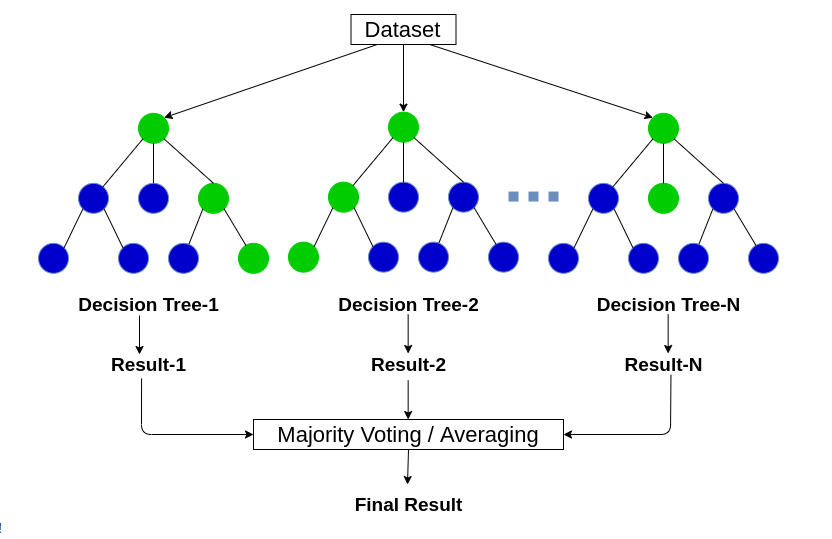

A random forest is a meta estimator that fits a number of classifying decision trees on various `sub-samples` of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The `sub-sample` size is controlled with the `max_samples` parameter if `bootstrap`=True (default), otherwise the whole dataset is used to build each tree.

Hyperparametters used:

- `n_estimators`: The number of trees in the forest.

- `n_jobs`: The number of jobs to run in parallel.

- `random_state`: Controls both the randomness of the bootstrapping of the samples used when building trees (if `bootstrap`=True) and the sampling of the features to consider when looking for the best split at each node (if `max_features` < n_features)

- `verbose`: Controls the verbosity when fitting and predicting.

[Details](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [ ]:
rfr = RandomForestRegressor(n_estimators = 530, n_jobs = -1, random_state = 2016, verbose = 1)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()


### Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

Hyperparametters used:

`n_components`:Desired dimensionality of output data. Must be strictly less than the number of features. The default value is useful for visualisation. For LSA, a value of 100 is recommended.

`random_stateint`: Used during randomized svd. Pass an int for reproducible results across multiple function calls.

[Details](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [ ]:
tsvd = TruncatedSVD(n_components=10, random_state = 2016)

## Create pipeline

In [ ]:
clf = pipeline.Pipeline([
        ('union', FeatureUnion(
                    transformer_list = [
                        ('cst',  custom_regression_vals()),  
                        ('txt1', pipeline.Pipeline([('s1', custom_txt_col(key='search_term')), ('tfidf1', tfidf), ('tsvd1', tsvd)])),
                        ('txt2', pipeline.Pipeline([('s2', custom_txt_col(key='product_title')), ('tfidf2', tfidf), ('tsvd2', tsvd)])),
                        ('txt3', pipeline.Pipeline([('s3', custom_txt_col(key='product_description')), ('tfidf3', tfidf), ('tsvd3', tsvd)])),
                        ('txt4', pipeline.Pipeline([('s4', custom_txt_col(key='brand')), ('tfidf4', tfidf), ('tsvd4', tsvd)]))
                        ],
                    transformer_weights = {
                        'cst': 1.0,
                        'txt1': 0.5,
                        'txt2': 0.25,
                        'txt3': 0.01,
                        'txt4': 0.5
                        },
                #n_jobs = -1
                )), 
        ('rfr', rfr)])
param_grid = {'rfr__max_features': [8], 'rfr__max_depth': [18]}

## GridSearchCV for model selection
GridSearchCV is a model selection step and this should be done after Data Processing tasks. It is used to train a machine learning model with multiple combinations of training hyper parameters and finds the best combination of parameters which optimizes the evaluation metric. It creates an exhaustive set of hyperparameter combinations and train model on each combination.

It is always good to compare the performances of Tuned and Untuned Models. This will cost us the time and expense but will surely give us the best results. The scikit-learn API is a great resource in case of any help.

Hyperparametters used:

- `estimator`: estimator object being used
- `param_grid`: dictionary that contains all of the parameters to try
- `scoring`: evaluation metric to use when ranking results
- `cv`: cross-validation, the number of cv folds for each combination of parameters

 [Details](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [ ]:
model = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1, cv = 2, verbose = 20, scoring=RMSE)
model.fit(X_train, y_train)

In [ ]:
print("Best parameters found by grid search:")
print(model.best_params_)

# Make submition

In [ ]:
pd.DataFrame({"id": id_test, "relevance": model.predict(X_test)}).to_csv('submission.csv',index=False)
print("--- Training & Testing: %s minutes ---" % round(((time.time() - start_time)/60),2))

# Result

Because the competition has closed, we will not see our rank in leaderboard

My score is about ~rank200

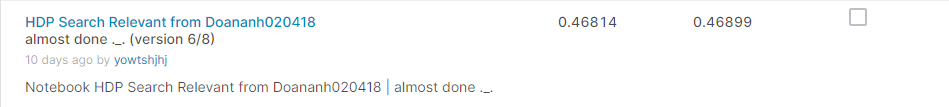